In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files

f = files.upload()

Saving names.txt to names.txt


In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset
def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---------->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_datset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
C = torch.randn((27, 2))

In [ ]:
C[5]

tensor([1.2937, 0.6491])

In [ ]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([1.2937, 0.6491])

In [ ]:
C[[1,2,3]]

tensor([[ 1.0956, -0.1219],
        [-0.0722,  0.7465],
        [-0.5463, -2.1347]])

In [ ]:
C[X].shape

torch.Size([228146, 3, 2])

In [ ]:
X[13]

tensor([0, 0, 1])

In [ ]:
X[30, 1]

tensor(8)

In [ ]:
C[X][30, 1]

tensor([-2.0629, -0.4006])

In [ ]:
C[8]

tensor([-2.0629, -0.4006])

In [ ]:
emb = C[X]

In [ ]:
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100, ))

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h.shape

torch.Size([228146, 100])

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27, ))

In [ ]:
logits = h @ W2 + b2

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [ ]:
prob.shape

torch.Size([228146, 27])

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: ignored

### Training

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [ ]:
losses = []
steps = []
lri = []

In [ ]:


for i in range(300000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #updat3
  if i < 100000:
    lr = 0.1
  elif i < 200000:
    lr = 0.05
  else:
    lr = 0.01
    
  for p in parameters:
    p.data += - lr * p.grad

  #track stats
  steps.append(i)
  losses.append(loss.log10().item())

print(loss.item())

2.0282704830169678


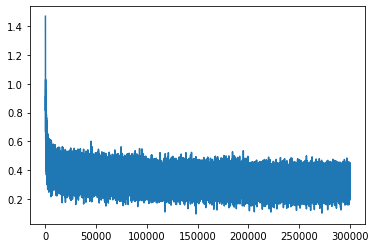

In [ ]:
plt.plot(steps, losses)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.1523, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.1003, grad_fn=<NllLossBackward0>)

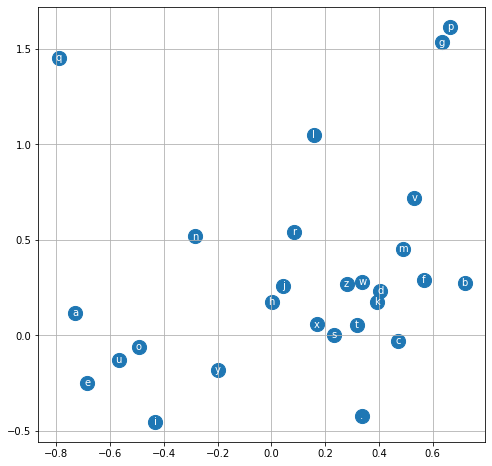

In [ ]:
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = 'center', va = 'center', color = 'white')
plt.grid('minor')

In [ ]:
block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))



carmahzatollivi.
kimri.
reh.
cassandan.
jazhabelle.
sara.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
join.
quint.
shois.
alianni.
wrothonielryni.
jaxen.
dusabee.
deci.
abette.
